# End-to-end trainig

In [1]:
LOAD_MODEL = None

In [2]:
# BAND = "r"
# NON_EXTENDED_ONLY = True

N_SRC = 10
BATCH_SIZE = 128
N_LCS = 100_000_000

DP1_ROOT = "../../data/dp1"
LSDB_WORKERS = 8
DEVICE = "cpu"

PLOT_MAGS = [18, 21, 25]

Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWar

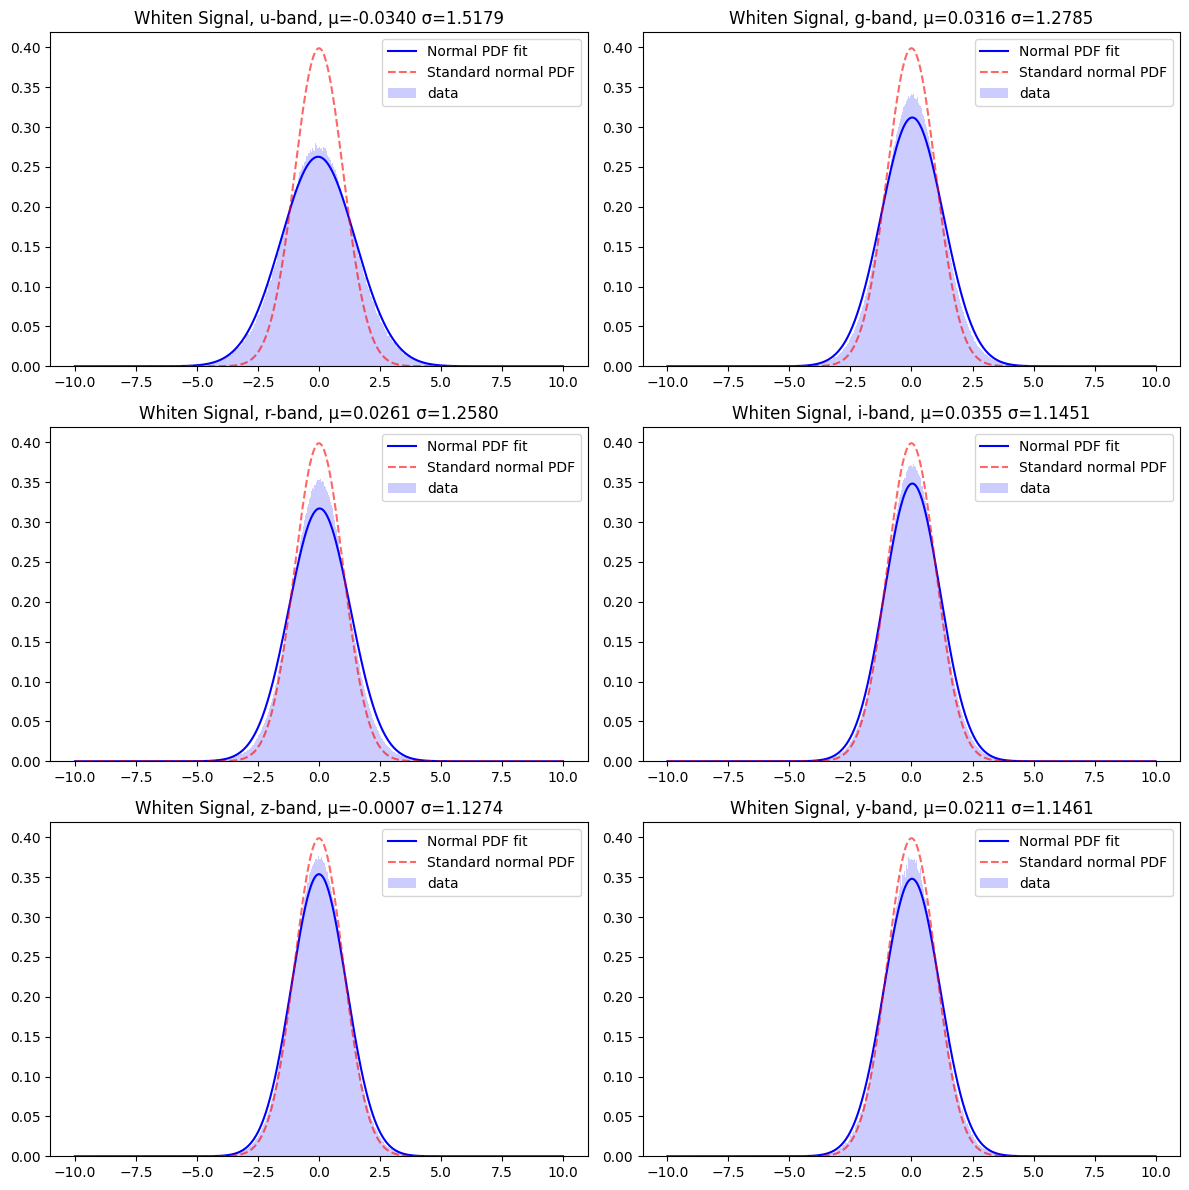

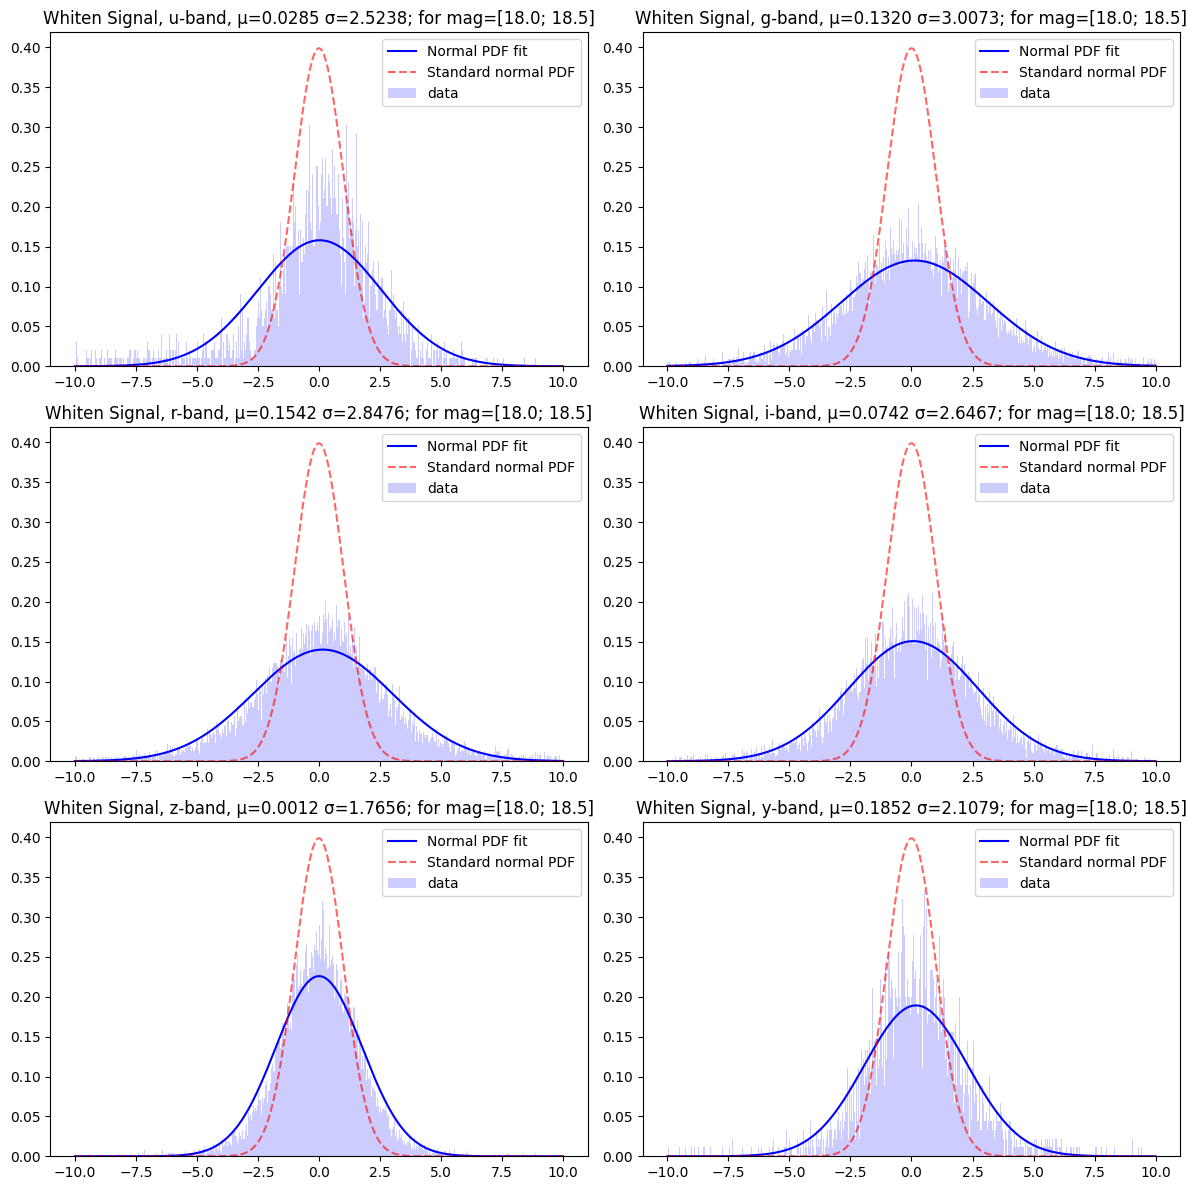

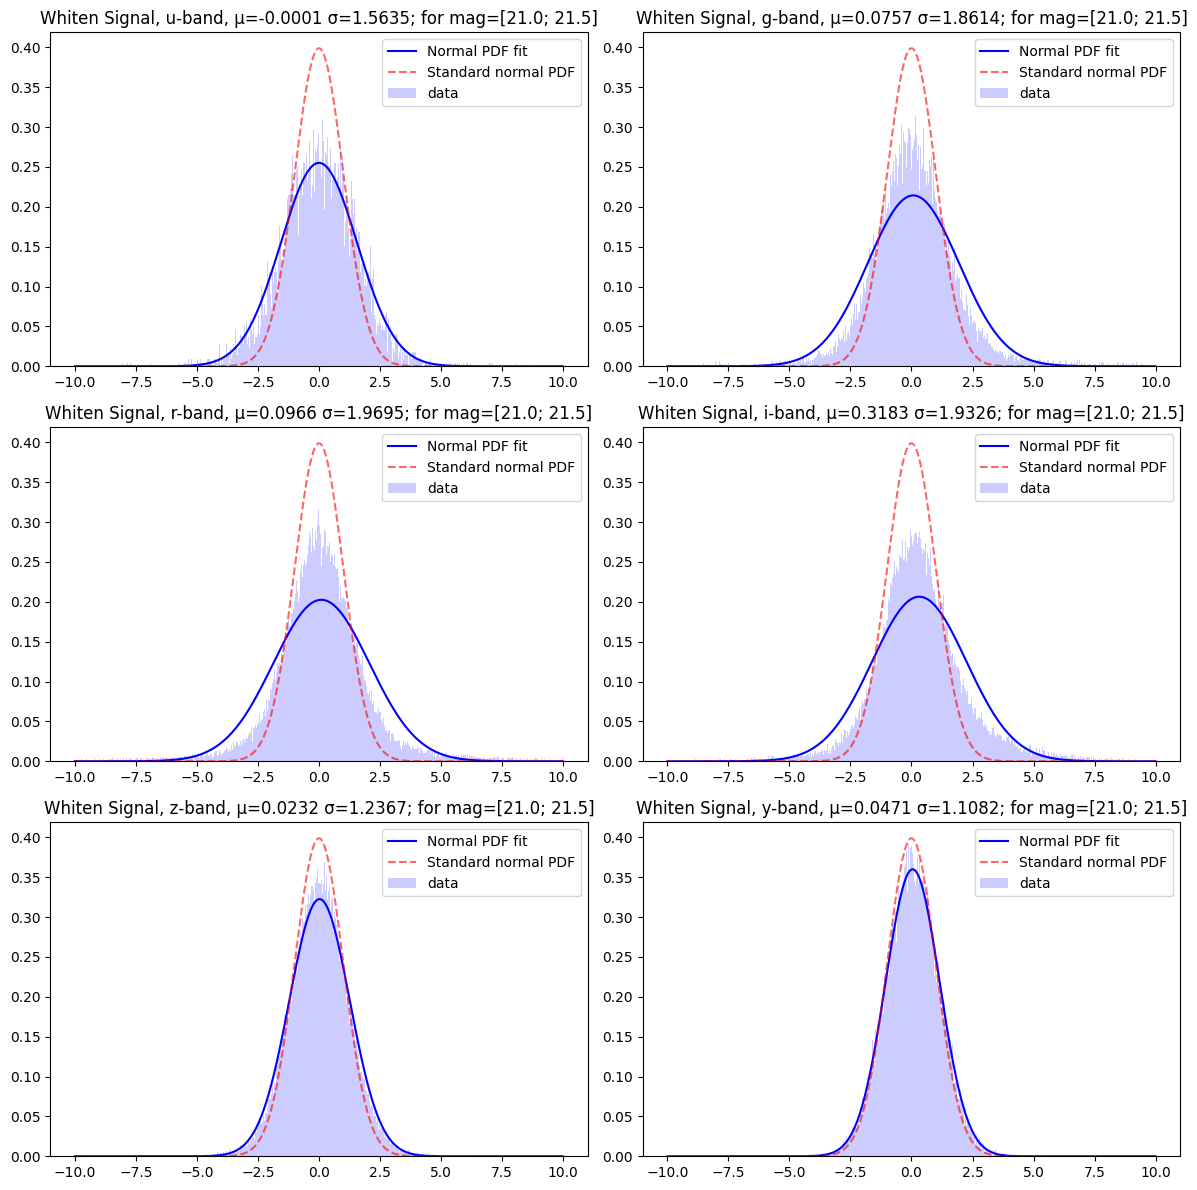

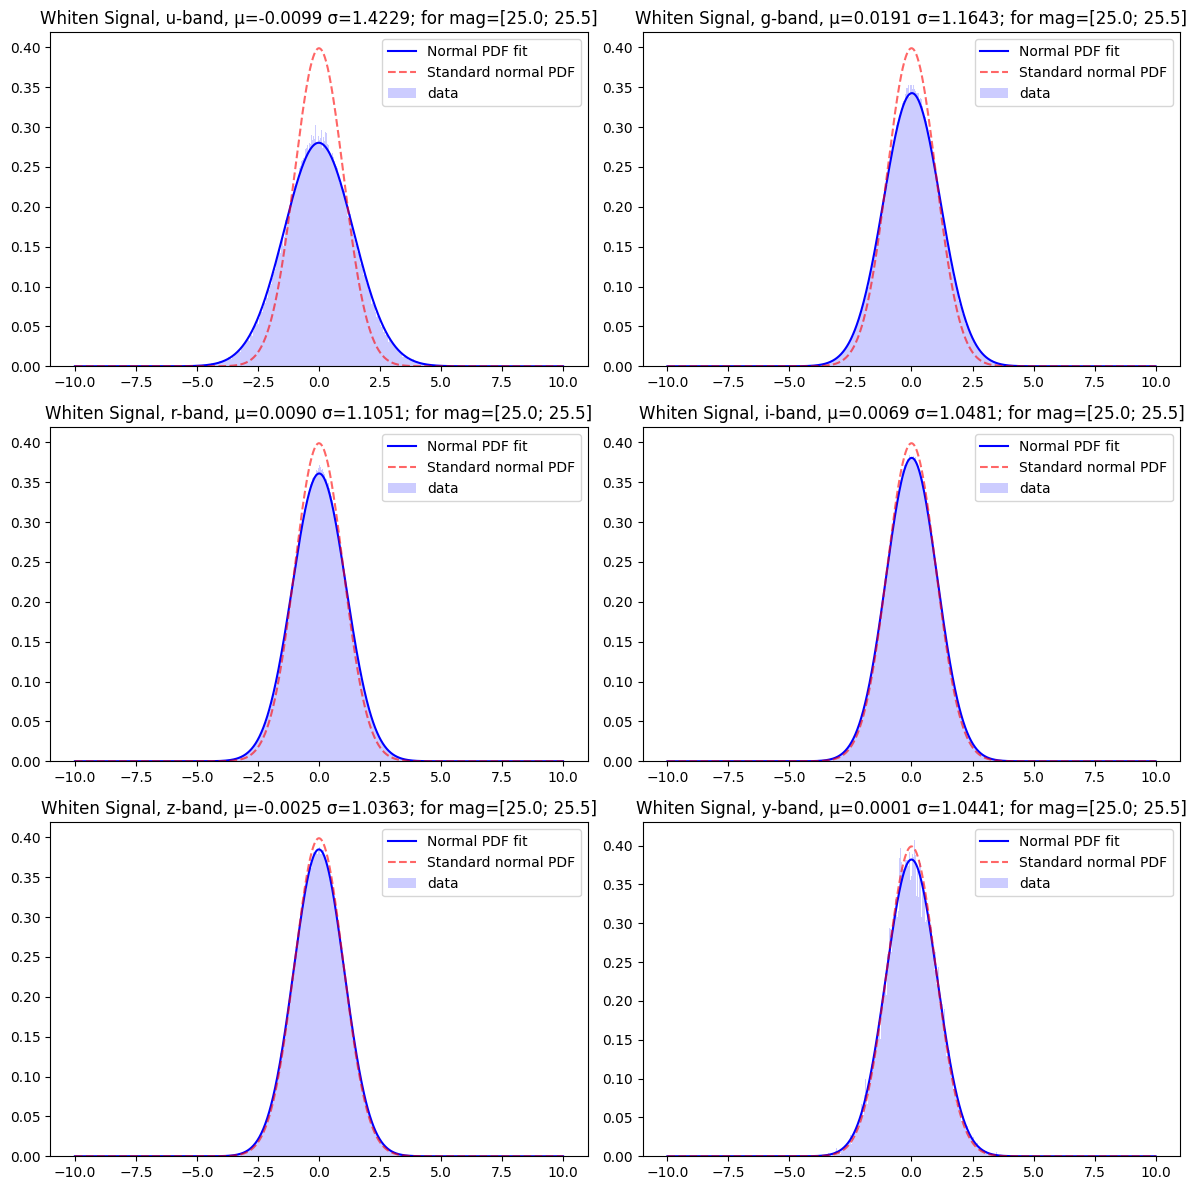

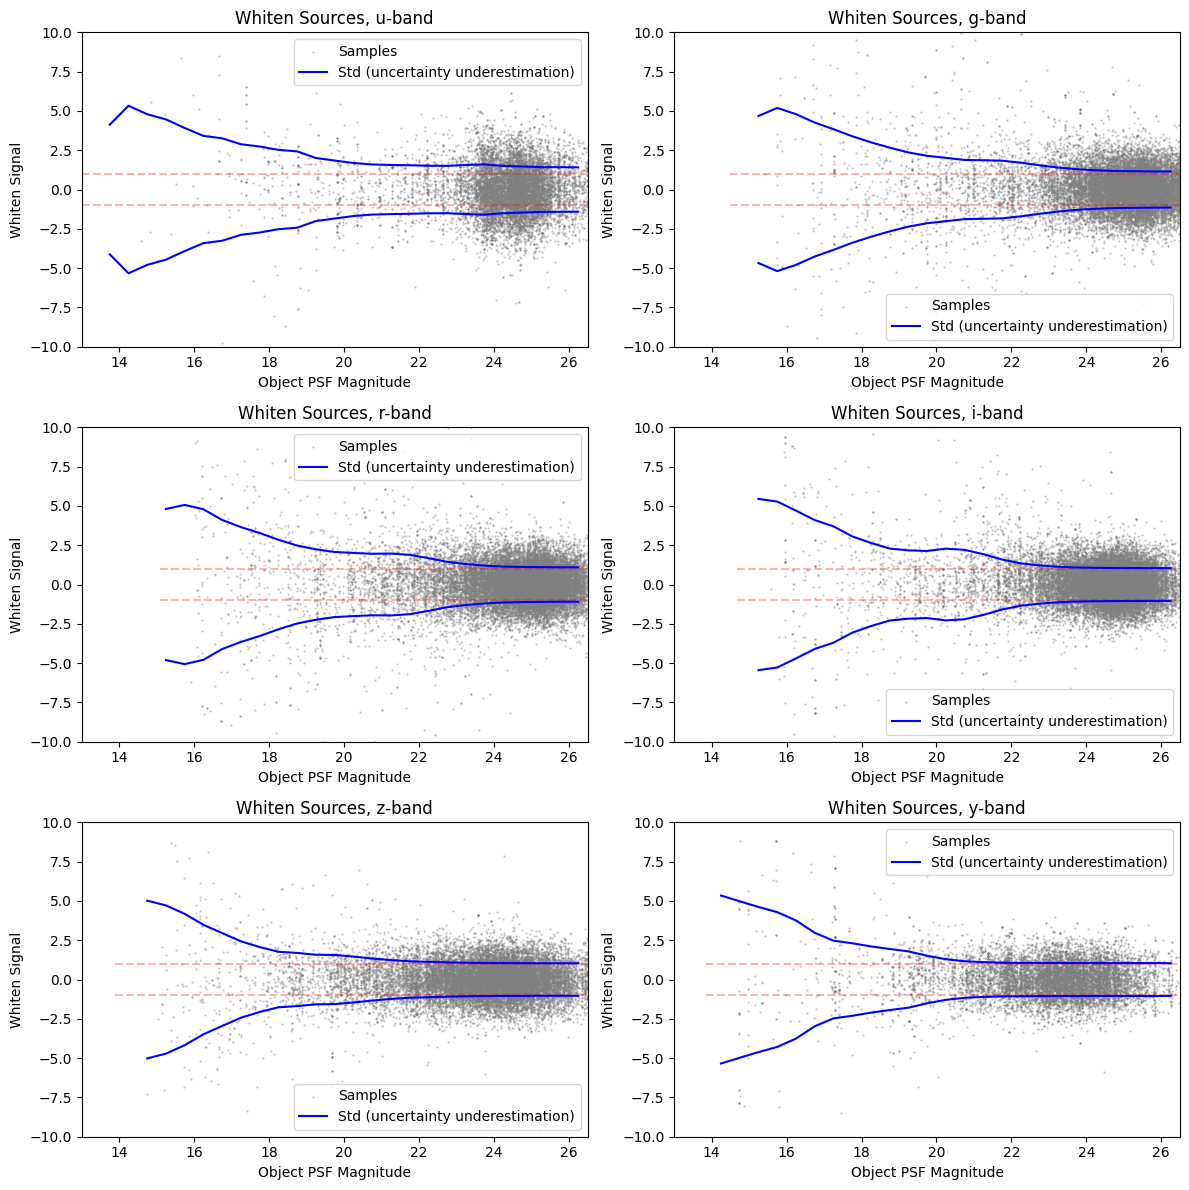

In [3]:
from uncle_val.pipelines import make_plots

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=None,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=None,
    n_samples=5,
    object_mags=[18, 21, 25],
)

In [4]:
# %load_ext tensorboard
# %tensorboard --logdir=runs

In [5]:
from uncle_val.learning.losses import minus_ln_chi2_prob_loss, kl_divergence_whiten_loss
from uncle_val.pipelines import run_dp1_mlp

model_path, model_columns = run_dp1_mlp(
    dp1_root=DP1_ROOT,
    n_workers=LSDB_WORKERS,
    n_src=N_SRC,
    n_lcs=N_LCS,
    loss_fn=kl_divergence_whiten_loss(lmbd=0.01, soft=20.0, kind="accum"),
    train_batch_size=BATCH_SIZE,
    val_batch_size=4098,
    snapshot_every=min(N_LCS // BATCH_SIZE // 50, 2048),
    start_tfboard=True,
    output_root="./runs",
    device=DEVICE,
    load_model_path=LOAD_MODEL,
)

Tensorboard Link: http://localhost:6006/
Dask Dashboard Link: http://127.0.0.1:8787/status


Training batch:   0%|          | 0/781250 [00:00<?, ?it/s]

2025-11-06 15:39:37,086 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:59158' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('apply_func-24f0587b2497b744f58c59643fafc027', 10), 'get_val_loss-dd1fc704d44a249f798cf9666c72ab4c', ('apply_func-24f0587b2497b744f58c59643fafc027', 15)} (stimulus_id='handle-worker-cleanup-1762461577.0863218')
2025-11-06 15:39:37,090 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('apply_func-23f95201d3b9c16ea6e2951235fb4578', 1))" coro=<Worker.execute() done, defined at /Users/hombit/.virtualenvs/uncle-val/lib/python3.13/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-11-06 15:39:37,093 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:59163' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('apply_func-24f0587b2497b744f58c59643fafc027', 11), ('ap

KeyboardInterrupt: 

In [6]:
print(model_path)
print(model_columns)

runs/2025-11-06_09-10/mlp.pt
['lc.x', 'lc.err', 'extendedness', 'lc.skyBg', 'lc.seeing', 'lc.expTime', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band']


### Train metrics

Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWar

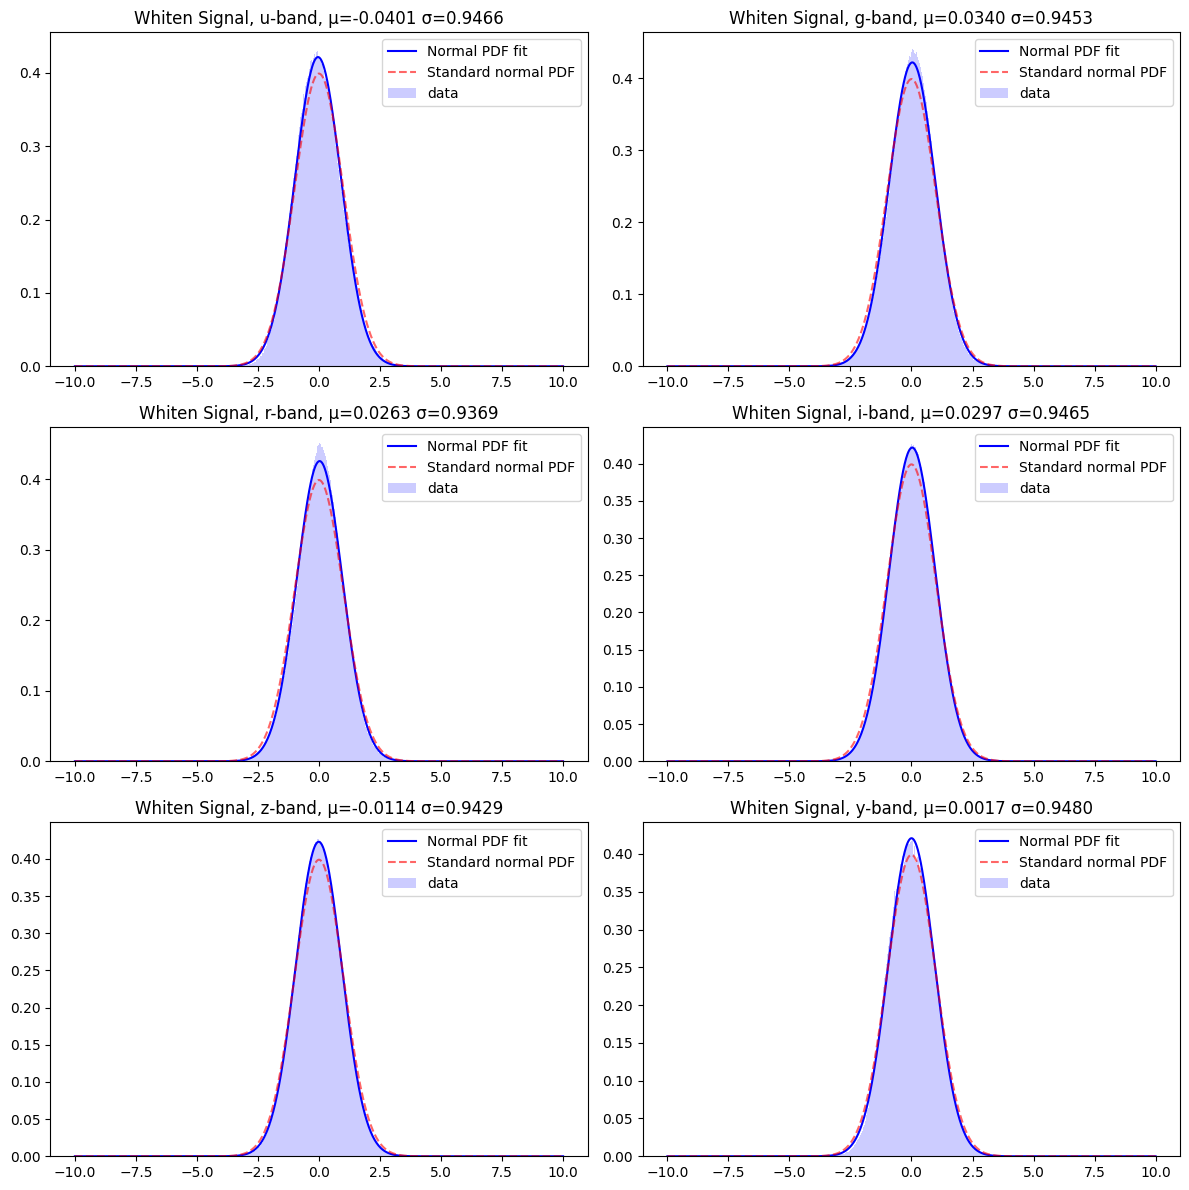

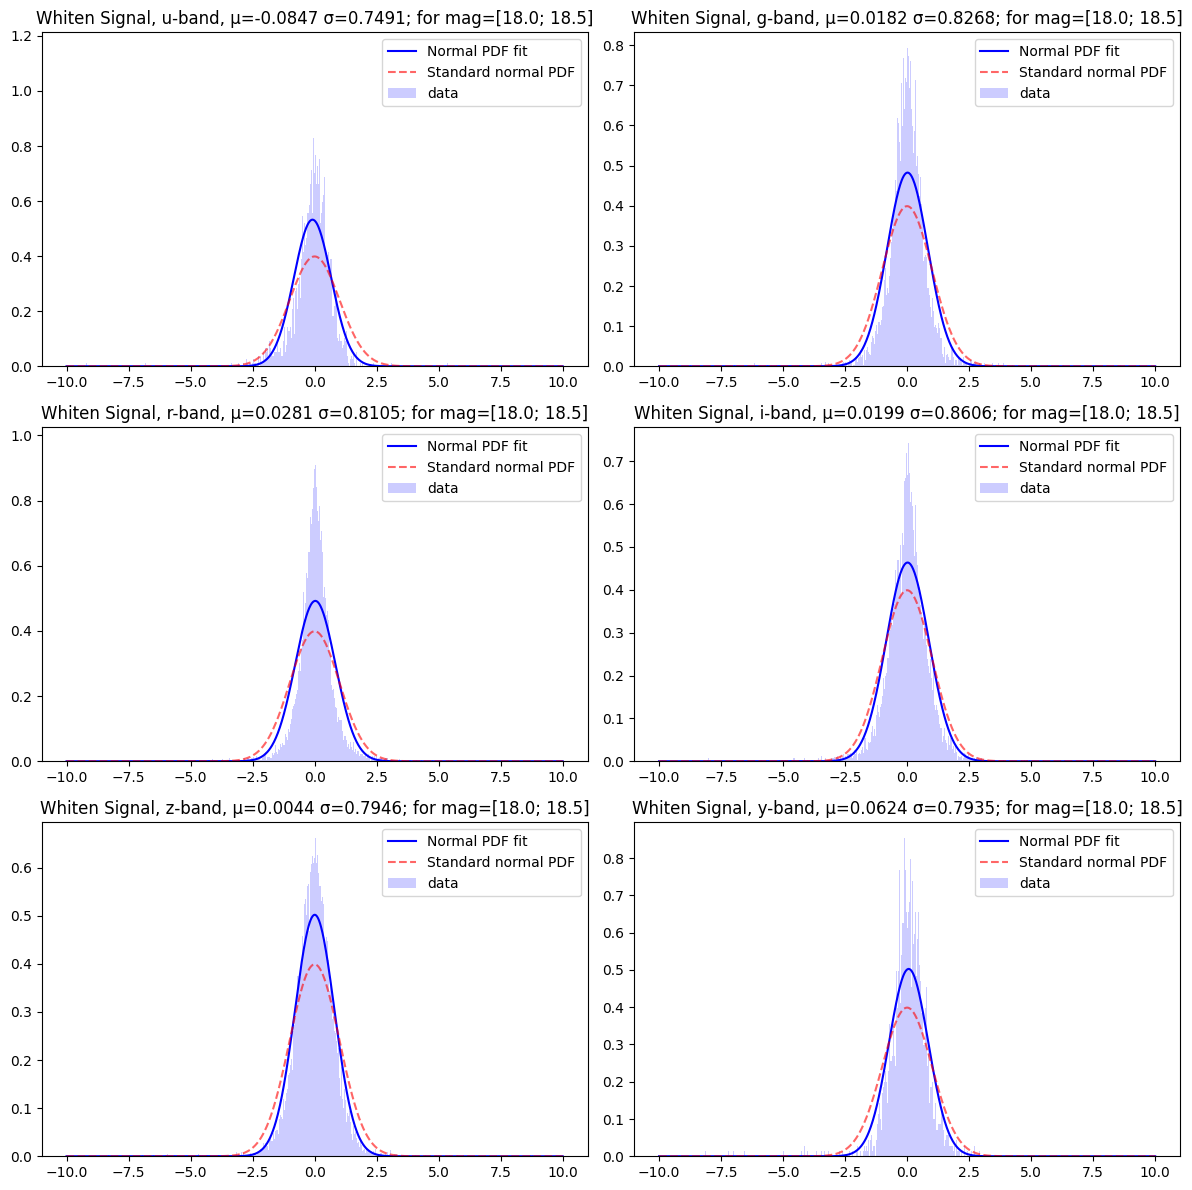

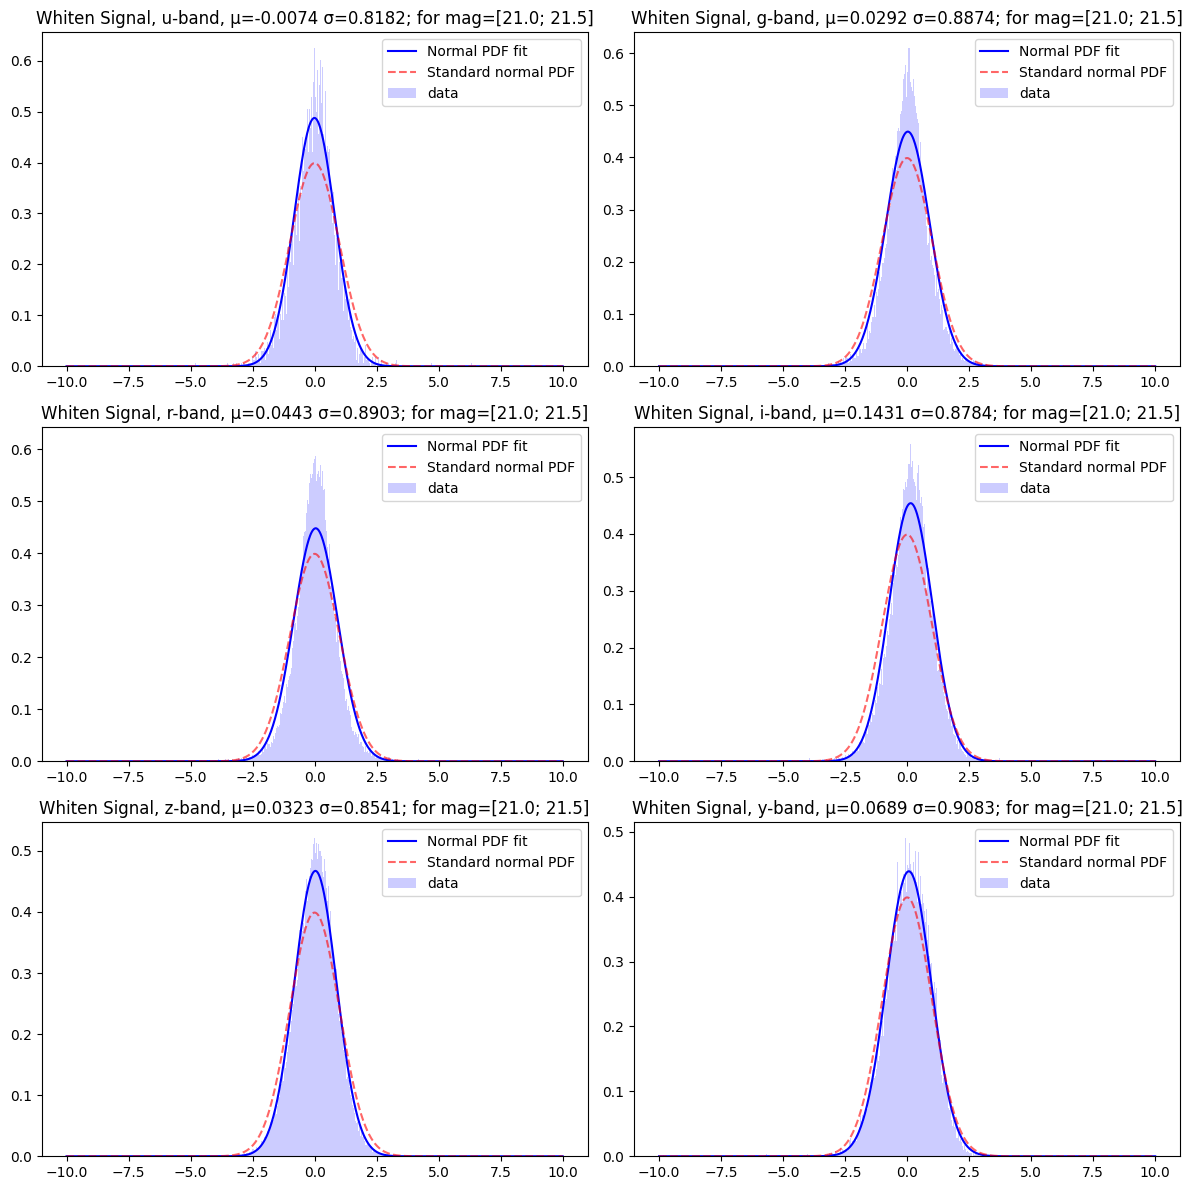

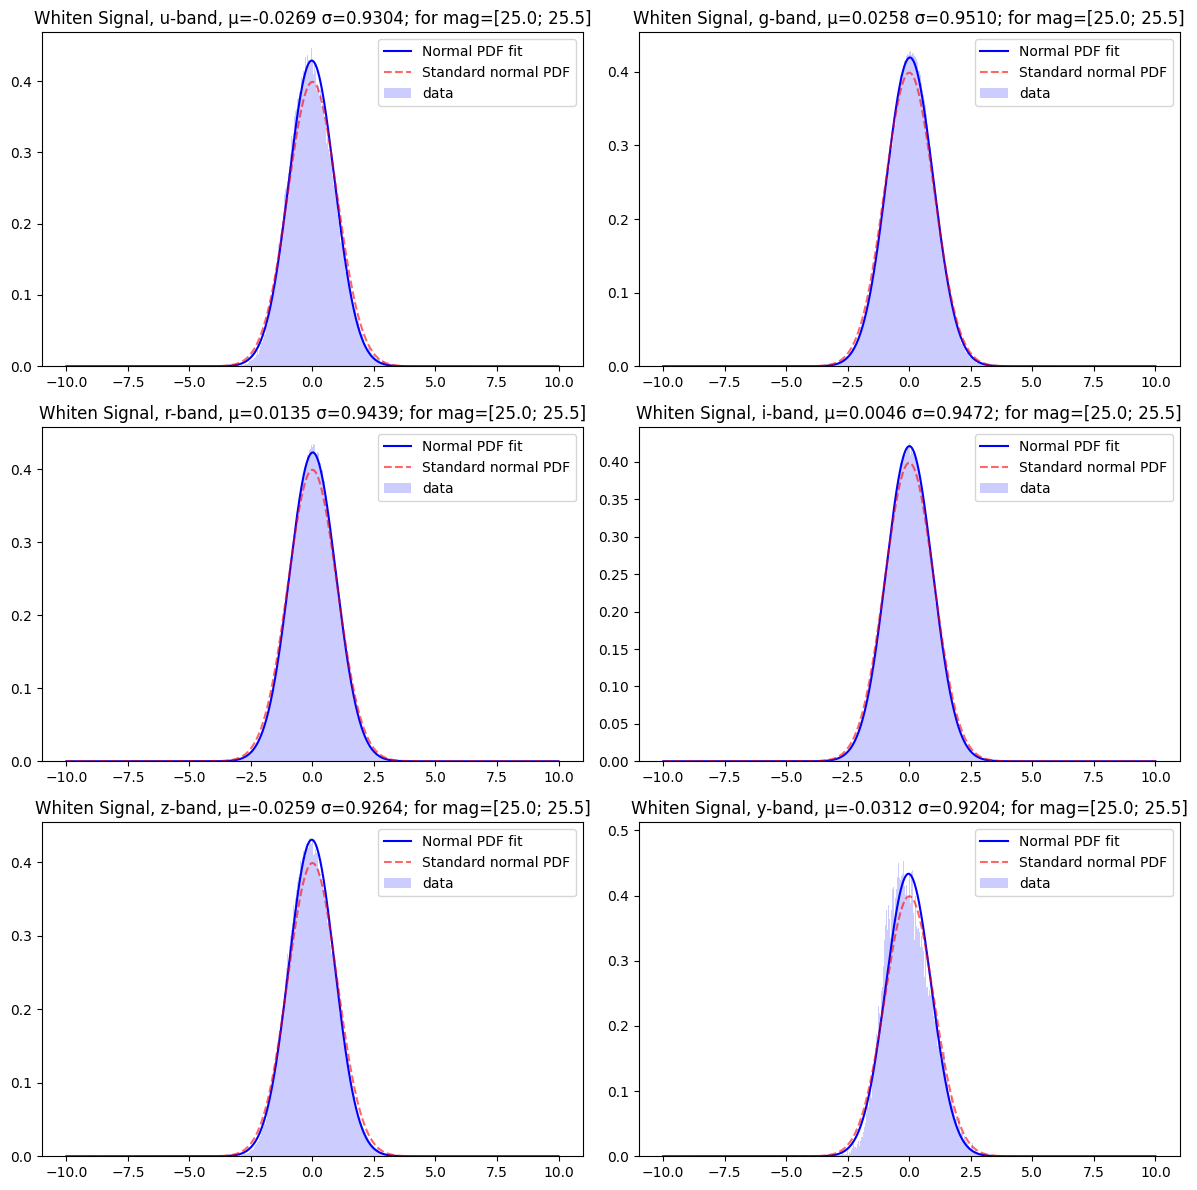

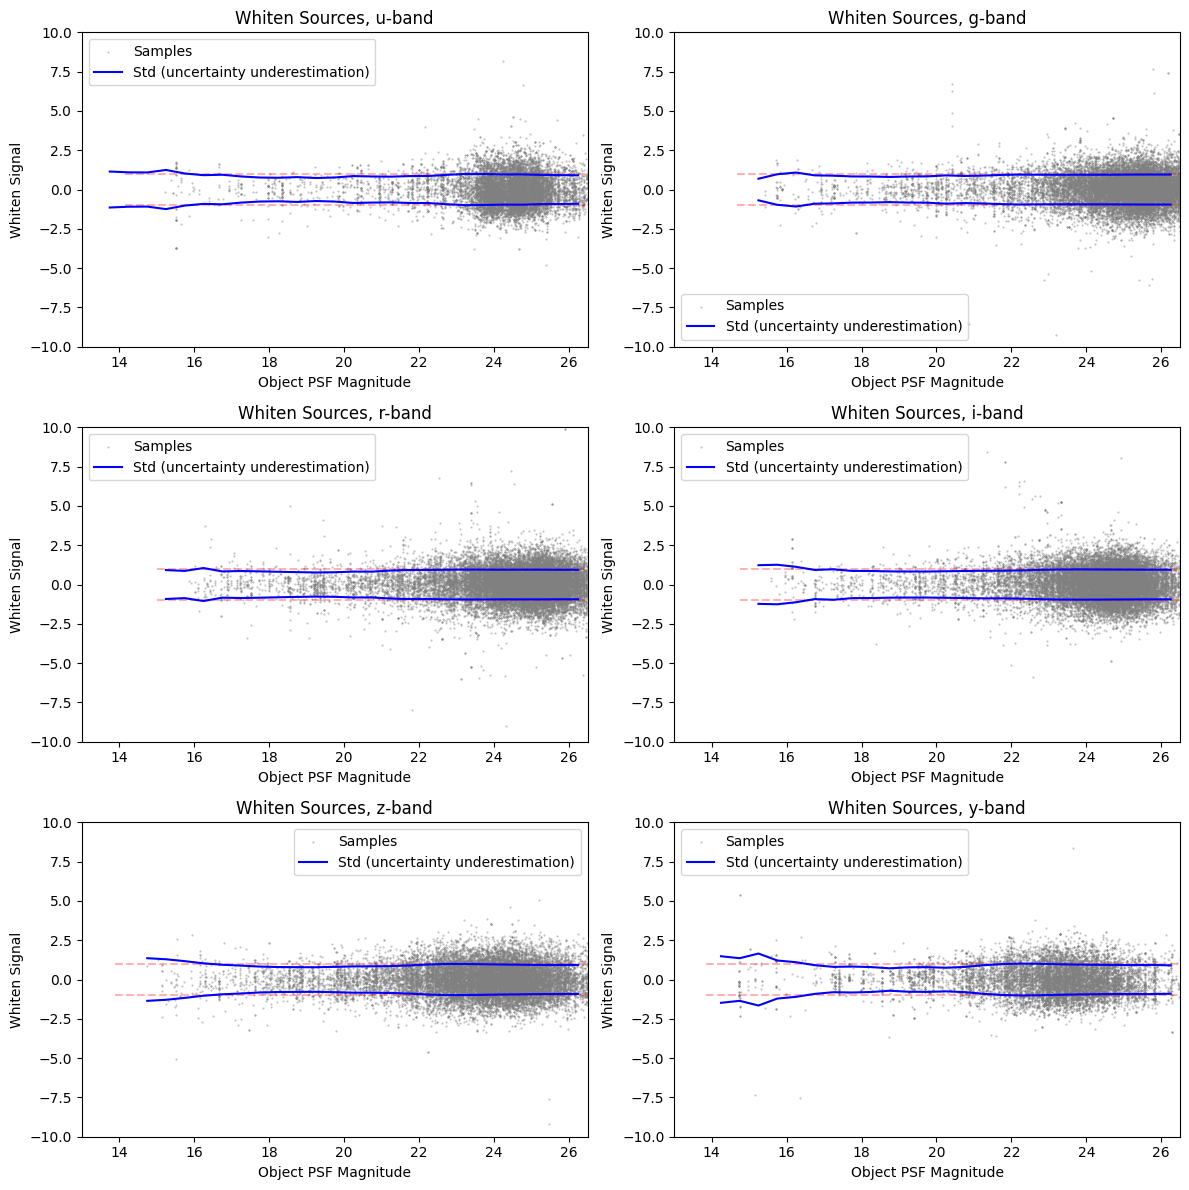

In [7]:
from uncle_val.pipelines import make_plots
from uncle_val.pipelines.splits import TRAIN_SPLIT

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=TRAIN_SPLIT,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=model_path,
    model_columns=model_columns,
    # model_path="runs/2025-10-10_20-39/mlp.pt",
    # model_columns=['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band'],
    device=DEVICE,
    n_samples=5,
    object_mags=[18, 21, 25],
)

### Validation metrics

In [ ]:
from uncle_val.pipelines import make_plots
from uncle_val.pipelines.splits import VALIDATION_SPLIT

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=VALIDATION_SPLIT,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=model_path,
    model_columns=model_columns,
    # model_path="runs/2025-10-10_20-39/mlp.pt",
    # model_columns=['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band'],
    device=DEVICE,
    n_samples=5,
    object_mags=[18, 21, 25],
)

### Test metrics

Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  transform_operator = _whitening_operator(sigma, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:56: NumbaPerformanceWar

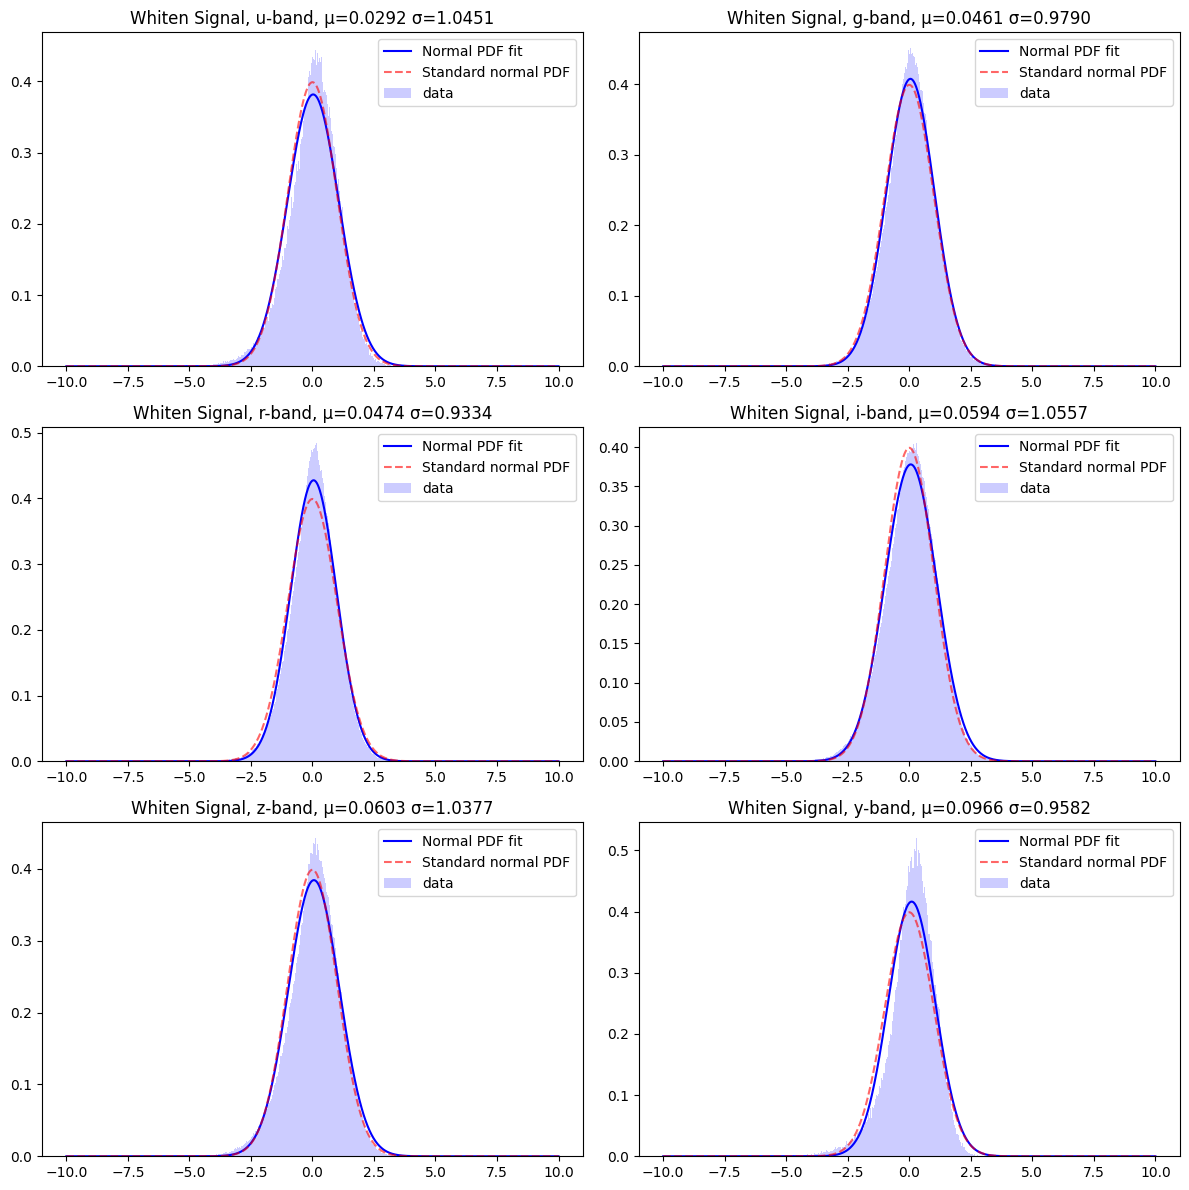

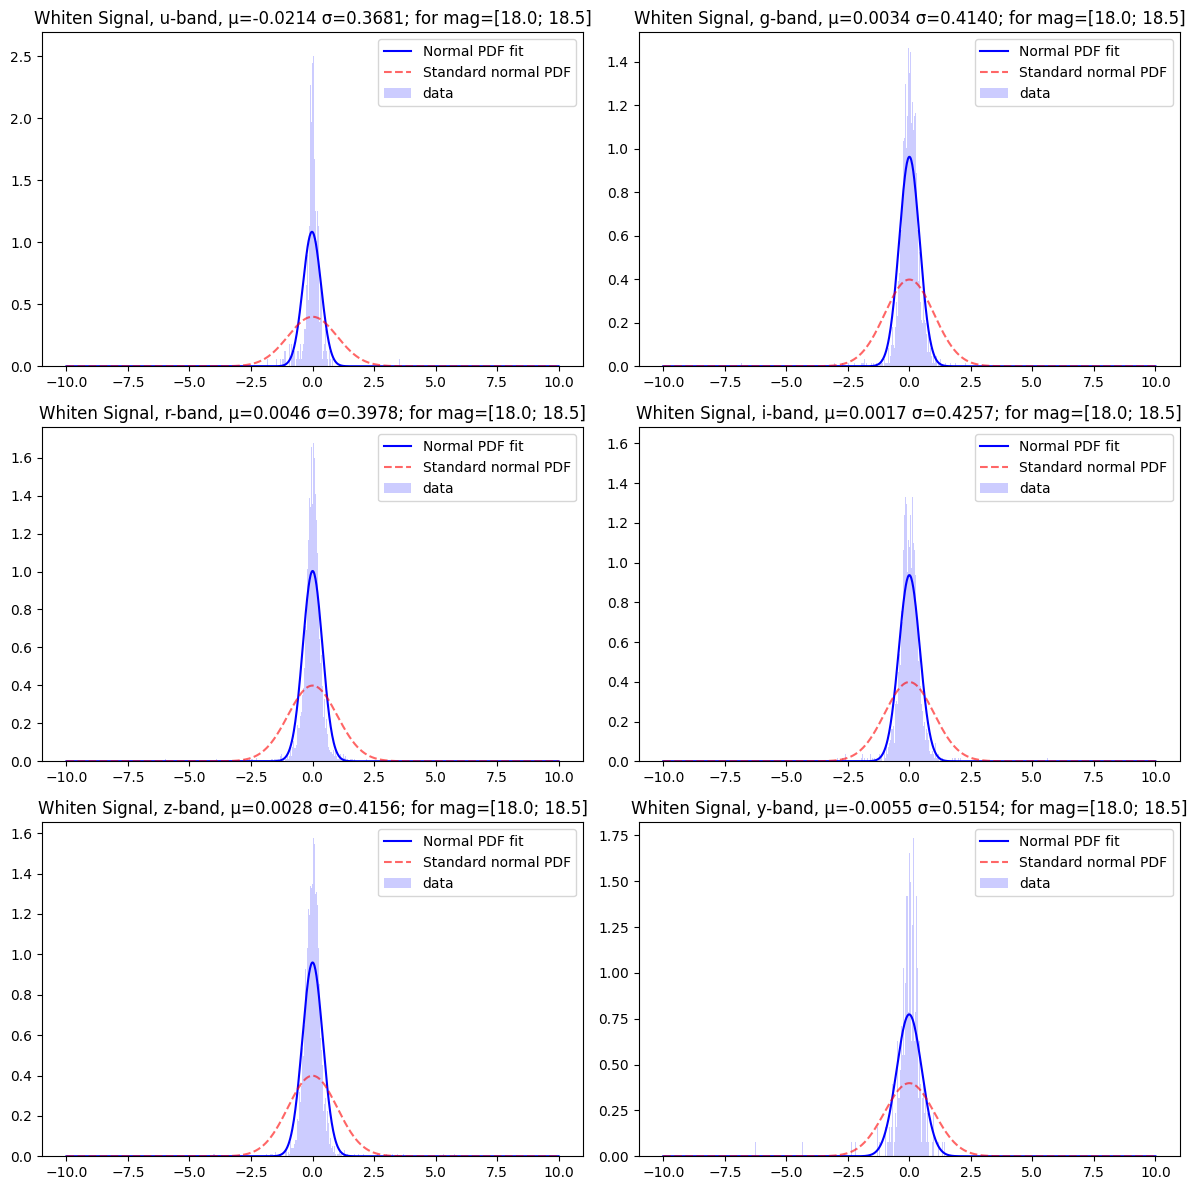

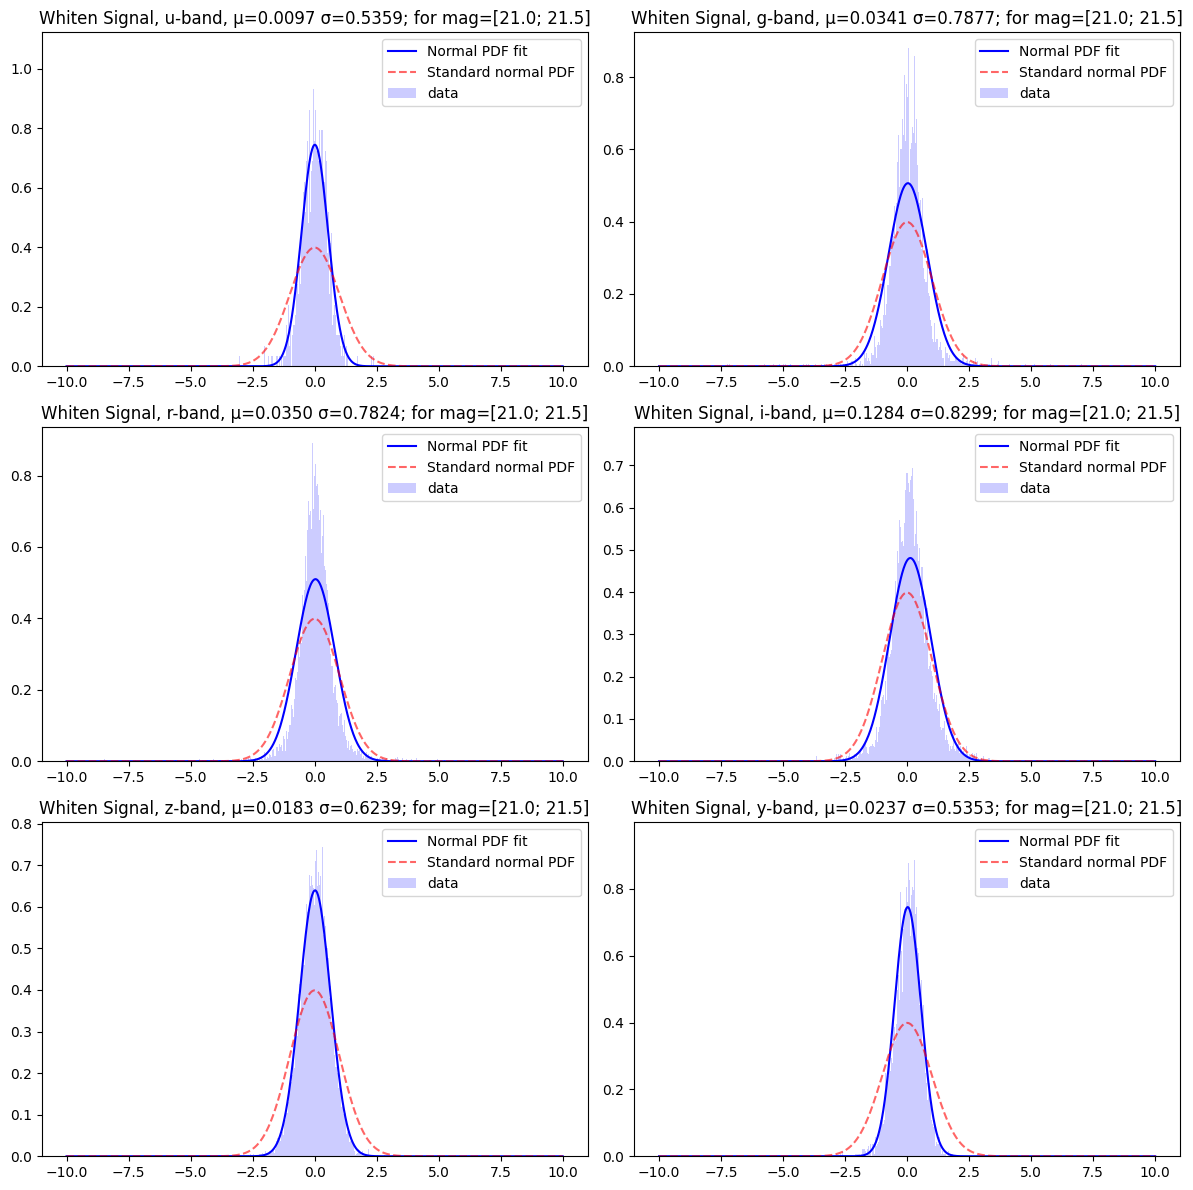

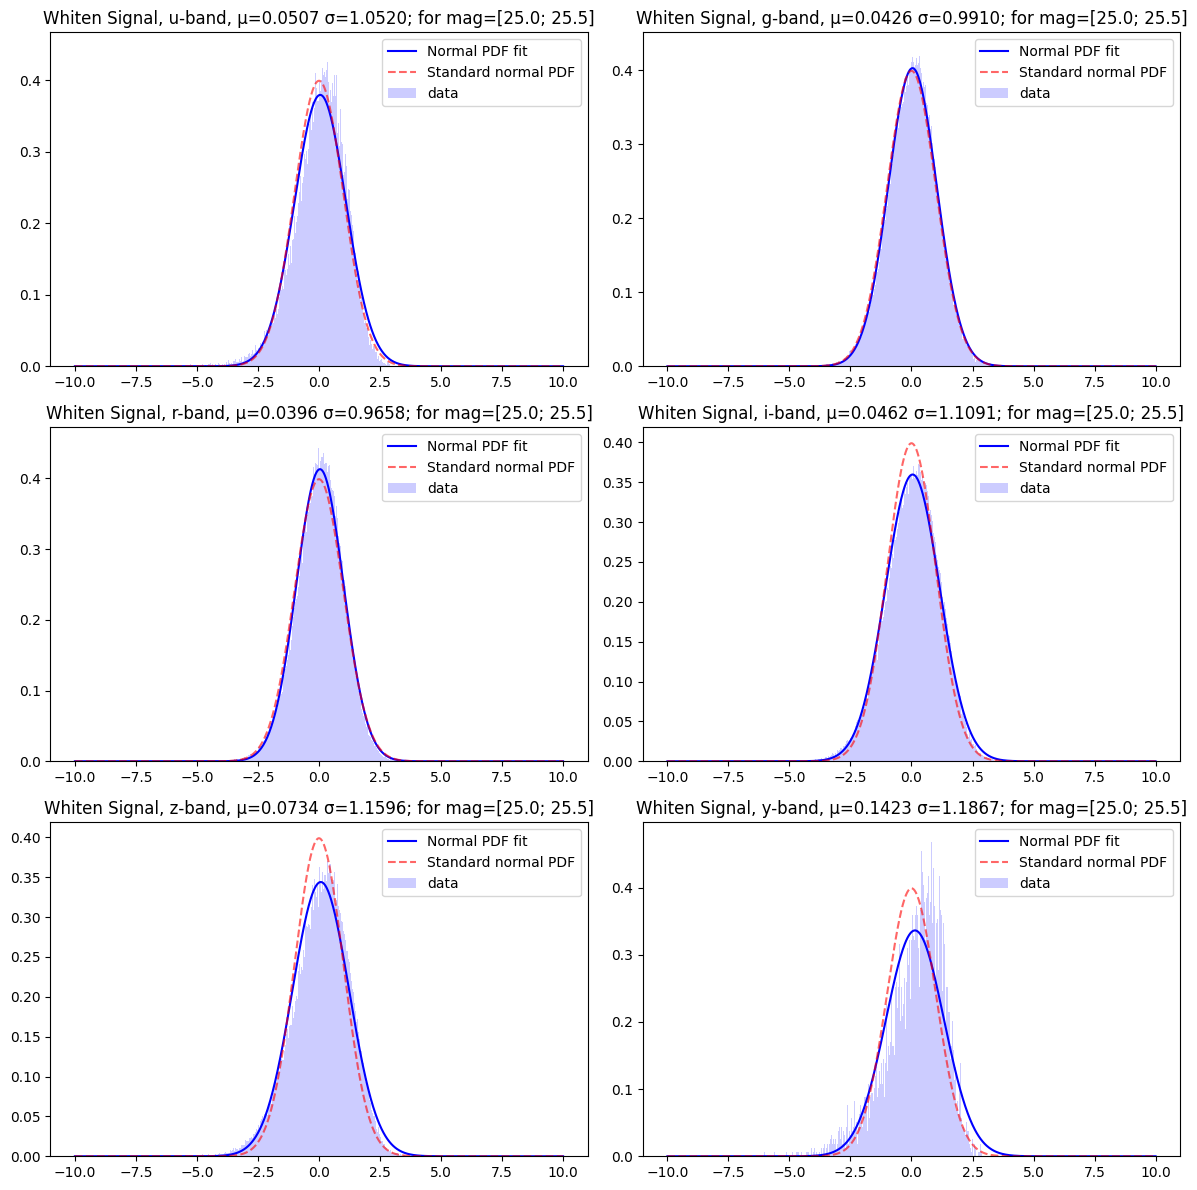

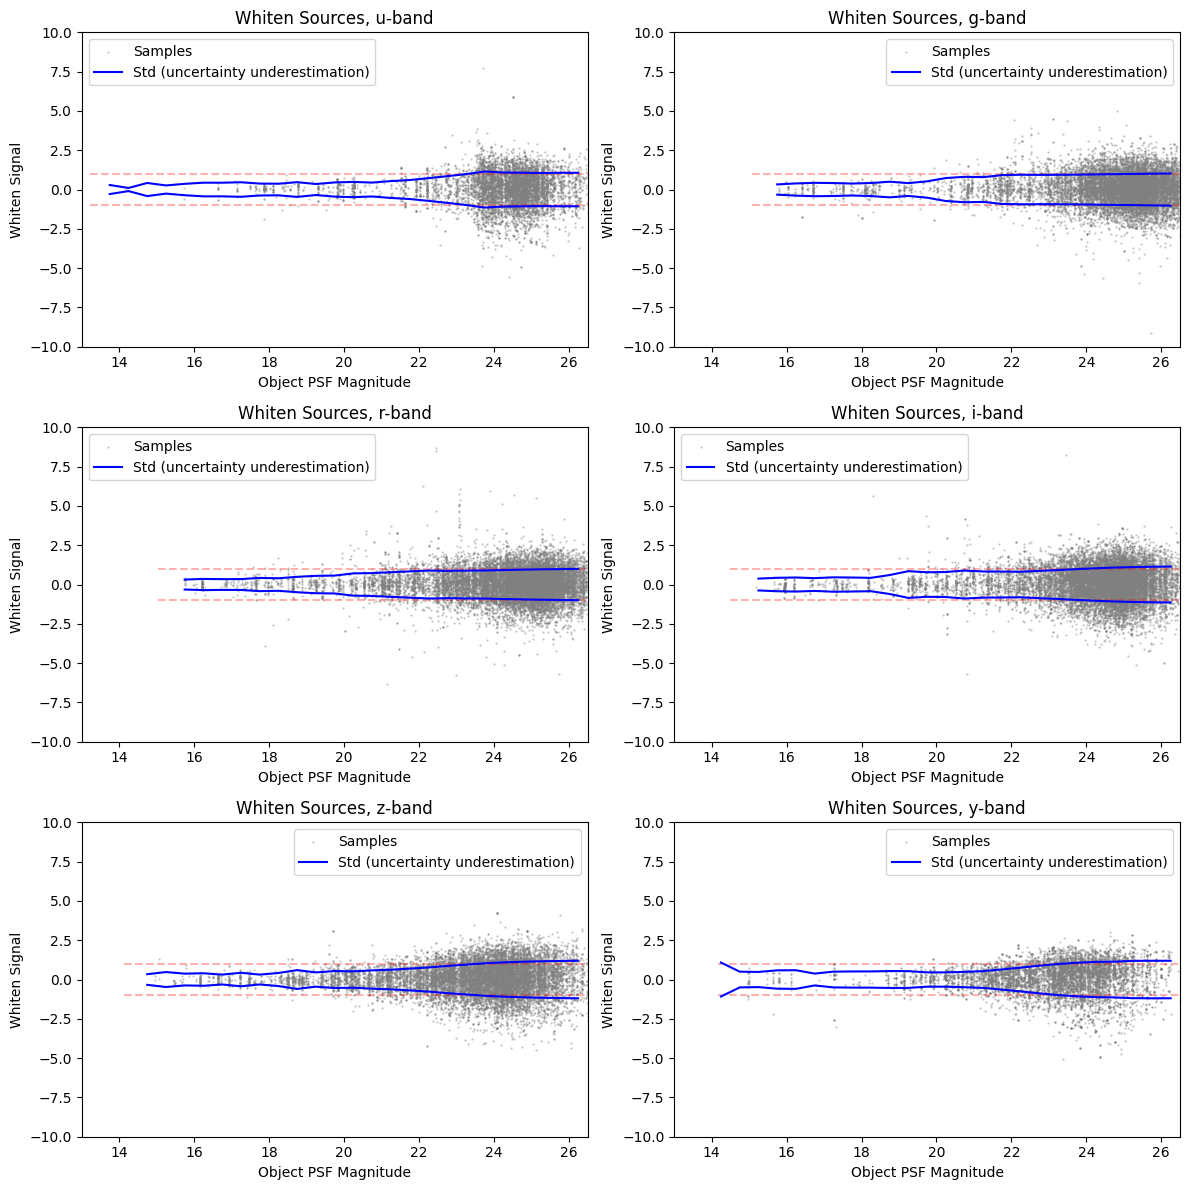

In [9]:
from uncle_val.pipelines import make_plots
from uncle_val.pipelines.splits import TEST_SPLIT

make_plots(
    dp1_root=DP1_ROOT,
    hash_range=TEST_SPLIT,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=model_path,
    model_columns=model_columns,
    # model_path="runs/2025-10-10_20-39/mlp.pt",
    # model_columns=['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band'],
    device=DEVICE,
    n_samples=5,
    object_mags=[18, 21, 25],
)